In [1]:
import os
import json
from tqdm import tqdm

from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.models import build_model
from sage.utils import seed_everything

from nilearn import plotting
import nibabel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)

path = "../result/[20220606-1538]repvgglr0.0001warmup0%"
#path =  ../result/[20220606-1627]convnext-tinylr0.0001warmup0%
# path = "../result/[20220521-1538]resnetlr0.0001warmup10%/"
config_file = os.path.join(path, "config.json")
with open(config_file, "r") as f:
    config = json.load(f)

In [3]:
data_args.load(config["data_args"])
training_args.load(config["training_args"])
misc_args.load(config["misc_args"])

In [4]:
seed_everything(misc_args.seed)
misc_args.output_dir = "./"
# data_args.batch_size = 1

logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

train_dataloader = get_dataloader(data_args, misc_args, "train", logger)
valid_dataloader = get_dataloader(data_args, misc_args, "valid", logger)
test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

2022-06-08 19:00:00,523 - root - INFO - Initialize dataset.
2022-06-08 19:00:00,545 - root - INFO - Successfully setup 1044 brains for Train
2022-06-08 19:00:00,545 - root - INFO - Initialize dataset.
2022-06-08 19:00:00,554 - root - INFO - Successfully setup 262 brains for Valid
2022-06-08 19:00:00,554 - root - INFO - Initialize dataset.
2022-06-08 19:00:00,562 - root - INFO - Successfully setup 146 brains for Test


In [5]:
import torch
from sage.models import build_model

model = build_model(training_args, logger)
model = model

model_path = os.path.join(path, "ckpts", "ep044.pt")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

2022-06-08 19:00:03,782 - root - INFO - Repvgg was chosen.
2022-06-08 19:00:03,819 - root - INFO - Repvgg has #params: 8 M.


<All keys matched successfully>

In [172]:
conv_layers = []
def find_conv(module):

    for name, layer in module.named_children():
        if name.startswith("conv"):
            conv_layers.append(layer)
        elif list(layer.named_children()) == []:
            find_conv(layer)
        else:
            find_conv(layer)
    else:
        return
        
find_conv(model)

In [119]:
from captum.attr import LayerGradCam, LayerAttribution

attributer = LayerGradCam(model, model.stage3[0].rbr_dense.conv)

In [129]:
preds = []
model = model.to("cpu")
maps = None
for x, y in tqdm(test_dataloader):

    attr = attributer.attribute(x)
    upsampled = LayerAttribution.interpolate(
        attr, (96, 96, 96), interpolate_mode="trilinear"
    ).cpu()
    z_normed = z_norm(upsampled)
    maps = torch.cat((maps, z_normed), dim=0) if maps is not None else z_normed

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


In [124]:
avg_map = average(maps, 0).squeeze()
null_val = torch.mode(avg_map.flatten(), 0).values

In [125]:
cut_coords = (48, 48, 48)
_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, np.eye(4))

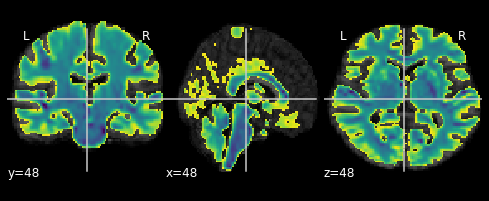

In [64]:
# model.stage0.rbr_dense.conv
display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), threshold=0.5)

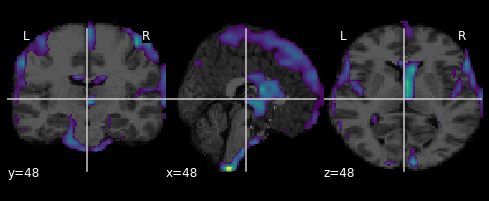

In [105]:
# model.stage1[0].rbr_dense.conv
display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), threshold=0.4)

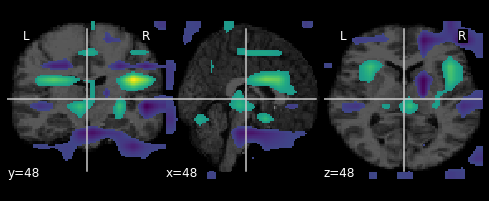

In [118]:
# model.stage2[1].rbr_dense.conv
display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), threshold=0.3)

/Users/daehyuncho/anaconda3/envs/research/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


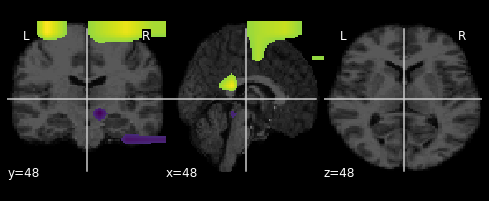

In [128]:
# model.stage3[0].rbr_dense.conv
display = plotting.plot_anat(_nifti(x[0][0].detach().numpy()), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), threshold=0.4)